In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from tueplots import figsizes
import matplotlib as mpl

from histaug.analysis.bootstrap import compare_bootstraps
from histaug.analysis.collect_results import load_results
from histaug.utils.display import RENAME_MODELS, RENAME_FEATURE_EXTRACTORS, FEATURE_EXTRACTOR_GROUPS

In [2]:
# MAGNIFICATION = "high"
MAGNIFICATION = "low"

assert MAGNIFICATION == "low", "Not implemented for high magnification"

augmentation_groups_to_compare = [
    "Macenko_slidewise",
    # "Macenko_patchwise",
    "simple_rotate",
    "all",
]
if MAGNIFICATION == "high":
    augmentation_groups_to_compare = ["Macenko_patchwise"]

results = load_results()

dfs = []
for aug in augmentation_groups_to_compare:
    df = compare_bootstraps(results, "augmentations", "none", aug)
    df["augmentation"] = aug
    dfs.append(df)

df = (
    pd.concat(dfs)
    .query("magnification == @MAGNIFICATION")
    .droplevel("magnification")
    .reset_index()
    .set_index(["augmentation", "model", "feature_extractor"])
    .drop(columns=["target"])
)
df

2024-05-20 21:42:22.140 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading results from cache
2024-05-20 21:42:22.292 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading bootstrapped_augmentations_none_vs_Macenko_slidewise_25_c4766ef27ebd833b03e149e0ce093c9b from cache
2024-05-20 21:42:22.464 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading bootstrapped_augmentations_none_vs_simple_rotate_25_c4766ef27ebd833b03e149e0ce093c9b from cache
2024-05-20 21:42:22.639 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading bootstrapped_augmentations_none_vs_all_25_c4766ef27ebd833b03e149e0ce093c9b from cache


train_dataset  \
augmentation      model        feature_extractor                      
Macenko_slidewise AttentionMIL bt                     tcga_crc_BRAF   
                               bt                     tcga_crc_BRAF   
                               bt                     tcga_crc_BRAF   
                               bt                     tcga_crc_BRAF   
                               bt                     tcga_crc_BRAF   
...                                                             ...   
all               Transformer  vits               tcga_brca_subtype   
                               vits               tcga_brca_subtype   
                               vits               tcga_brca_subtype   
                               vits               tcga_brca_subtype   
                               vits               tcga_brca_subtype   

                                                        test_dataset  \
augmentation      model        feature_extractor                       
Macenko_slidewise AttentionMIL bt                     cptac_crc_BRAF   
                               bt                     cptac_crc_BRAF   
                               bt                     cptac_crc_BRAF   
                               bt                     cptac_crc_BRAF   
                               bt                     cptac_crc_BRAF   
...                                                              ...   
all               Transformer  vits               cptac_brca_subtype   
                               vits               cptac_brca_subtype   
                               vits               cptac_brca_subtype   
                               vits               cptac_brca_subtype   
                               vits               cptac_brca_subtype   

                                                  auroc_diff  
augmentation      model        feature_extractor              
Macenko_slidewise AttentionMIL bt                   0.047101  
                               bt                   0.105676  
                               bt                   0.048889  
                               bt                   0.079106  
                               bt                  -0.021120  
...                                                      ...  
all               Transformer  vits                 0.042156  
                               vits                 0.005171  
                               vits                 0.101888  
                               vits                 0.087075  
                               vits                 0.036674  

[141750 rows x 3 columns]

2024-05-20 21:42:23.973 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading norm_diff__feature_extractor__magnification_augmentations_model_target from cache


(14,) (14, 8)


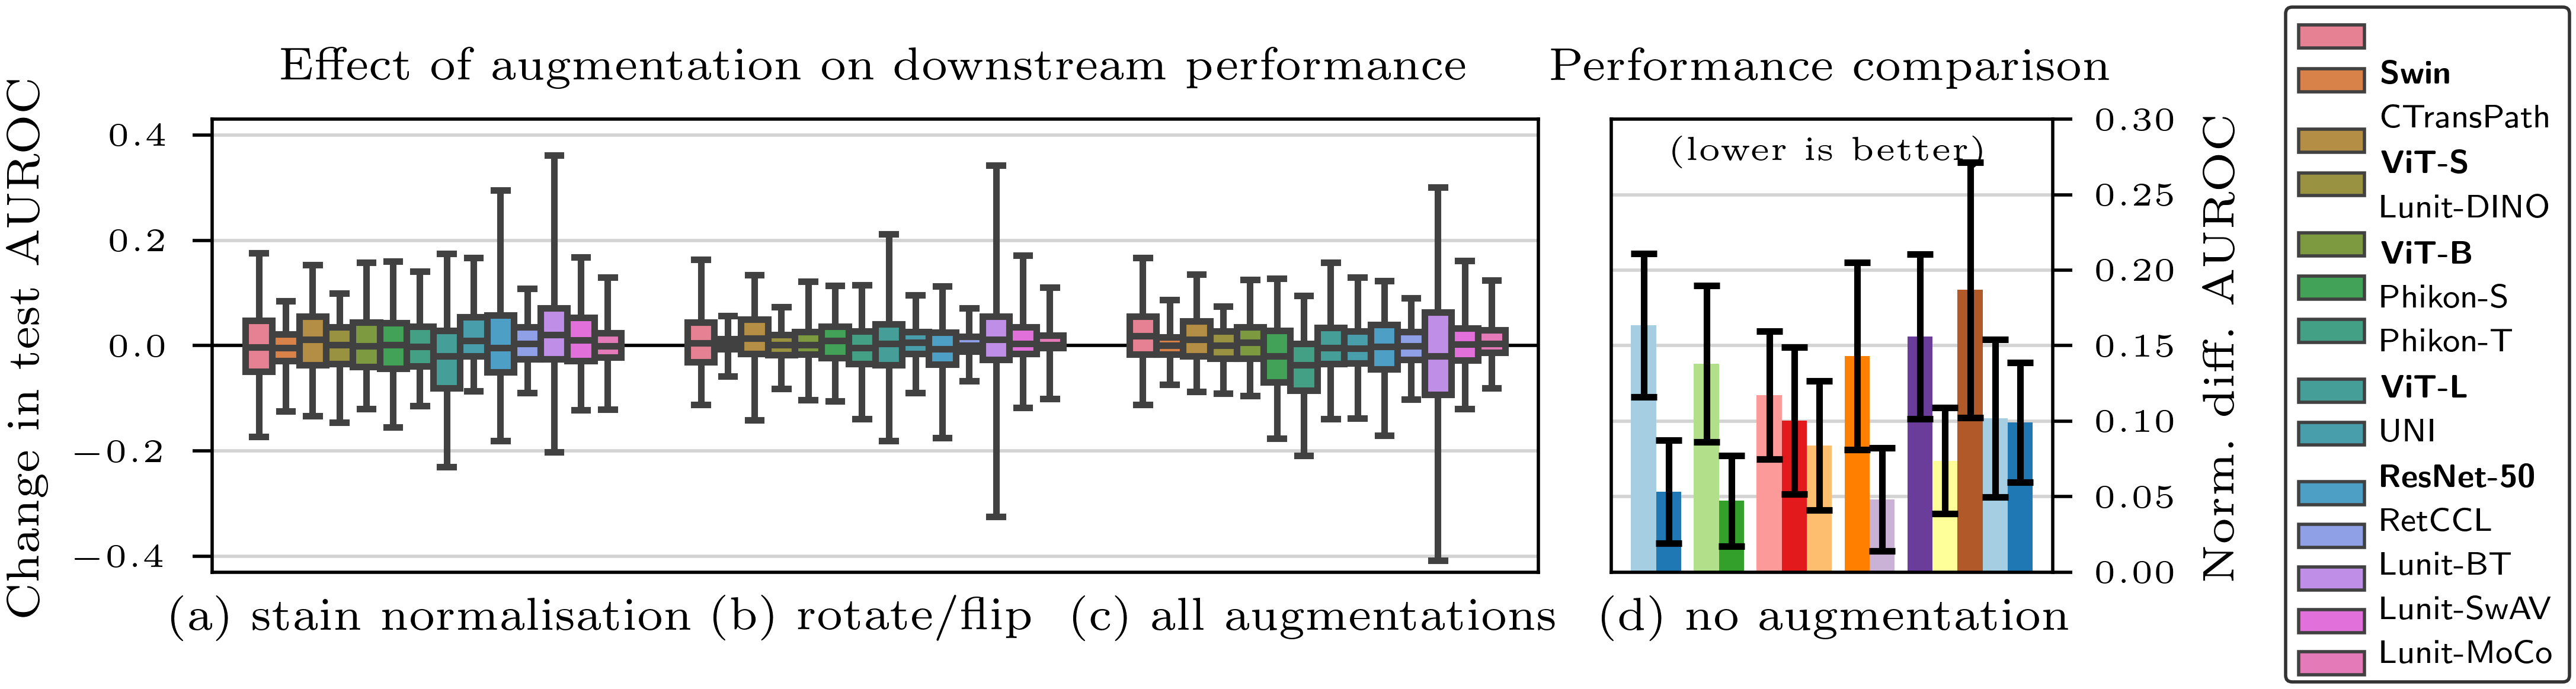

In [3]:
models = ["AttentionMIL", "Transformer", "MeanAveragePooling"]
models = ["AttentionMIL"]

from histaug.analysis.collect_results import compute_results_table
from histaug.utils import rc_context, savefig


def compute_overall_average(df):
    # Computer overall mean and std (across targets)
    targets = df.columns.get_level_values("target").unique()
    assert "average" not in targets
    n_targets = len(targets)
    overall_mean = df.stack().query("stats == 'mean'").droplevel("stats").sum(axis="columns").divide(n_targets)
    overall_std = (
        df.stack().query("stats == 'std'").droplevel("stats").pow(2).sum(axis="columns").divide(n_targets).pow(0.5)
    )
    df["average", "mean"] = overall_mean
    df["average", "std"] = overall_std
    return df


def format_feature_extractor(new_name: str):
    if new_name in FEATURE_EXTRACTOR_GROUPS:
        new_name = f"\\textbf{{{new_name}}}"
    new_name = f"\\textsf{{{new_name}}}"
    return new_name


df["Feature extractor"] = (
    df.index.get_level_values("feature_extractor").map(RENAME_FEATURE_EXTRACTORS).map(format_feature_extractor)
)
df["Augmentation"] = df.index.get_level_values("augmentation").map(
    lambda x: {
        "Macenko_slidewise": "\\textrm{(a) stain normalisation}",
        "simple_rotate": "\\textrm{(b) rotate/flip}",
        "all": "\\textrm{(c) all augmentations}",
    }.get(x, x)
)

w, h = figsizes.eccv2024()["figure.figsize"]

with rc_context(h=0.9 * len(models), default_smaller=2):
    fig = plt.figure()
    gridspecs = fig.add_gridspec(len(models), 2, width_ratios=[75, 25])

    sns.set_palette("Paired")

    for i_model, model in enumerate(models):
        gs1 = gridspecs[i_model, 0]
        gs2 = gridspecs[i_model, 1]

        # Create the first subplot
        ax1 = fig.add_subplot(gs1)

        # horizontal line at 0
        hline = plt.axhline(0, color="black", linewidth=0.5)

        # Boxplot with 95% confidence interval
        boxplot = sns.boxplot(
            data=df.query("model == @model"),
            x="Augmentation",
            y="auroc_diff",
            hue="Feature extractor",
            hue_order=[
                format_feature_extractor(RENAME_FEATURE_EXTRACTORS[x])
                for x in itertools.chain.from_iterable(FEATURE_EXTRACTOR_GROUPS.values())
            ],
            # ensure 95% confidence interval is shown
            showfliers=False,
            whis=[2.5, 97.5],
            # show all data points
            # showmeans=True,
            width=0.85,
        )

        # plt.legend(loc="lower right", ncol=2, bbox_to_anchor=(1.0, 1.05), borderaxespad=0.0)
        # plt.legend(loc="upper left", ncol=2)
        plt.gca().get_legend().remove()
        plt.ylabel("Change in test AUROC")
        plt.xlabel("")

        # plt.xticks(rotation=45, ha="right")

        # light grey grid
        plt.grid(axis="y", color="lightgrey")
        plt.xlabel("")
        plt.gca().tick_params(axis="x", which="both", length=0)
        plt.title(
            f"Effect of augmentation on downstream performance"
            if len(models) == 1
            else f"Effect of augmentation on performance ({RENAME_MODELS[model]})"
        )

        ######################

        # Create the second subplot
        ax2 = fig.add_subplot(gs2)

        d = (
            compute_results_table(
                results,
                keep_fixed=("magnification", "augmentations", "model", "target"),
                vary="feature_extractor",
            )
            .query("magnification == @MAGNIFICATION")
            .stack("feature_extractor")
            .unstack("target")
            .swaplevel("target", "stats", axis=1)
            .sort_index(axis=1)
        )
        d = compute_overall_average(d)["average"]
        d["group"] = d.index.get_level_values("feature_extractor").map(
            {extractor: group for group, extractors in FEATURE_EXTRACTOR_GROUPS.items() for extractor in extractors}
        )
        d = d.query("model == @model and augmentations=='none'")
        d["aug"] = d.index.get_level_values("augmentations").map({"none": "no augmentation"})

        # sns.barplot(
        #     data=d.reset_index(),
        #     x="aug",
        #     y="mean",
        #     hue="feature_extractor",
        #     hue_order=RENAME_FEATURE_EXTRACTORS.keys(),
        # )

        # add small text at top of ax with "(lower is better)"
        plt.gca().text(
            0.5,
            0.965,
            "(lower is better)",
            horizontalalignment="center",
            verticalalignment="top",
            transform=plt.gca().transAxes,
            fontsize=5,
            # white background
            # bbox=dict(facecolor="white", alpha=1.0, edgecolor="none", pad=0.3, boxstyle="square"),
        )

        # order d feature extractors by the way they appear in RENAME_FEATURE_EXTRACTORS
        d = d.reset_index()
        d["feature_extractor"] = pd.Categorical(d["feature_extractor"], RENAME_FEATURE_EXTRACTORS.keys(), ordered=True)
        d = d.sort_values("feature_extractor")

        xs = []
        for group, extractors in FEATURE_EXTRACTOR_GROUPS.items():
            for i in range(len(extractors)):
                xs.append(1.5 if i == 0 else 1)
        xs = np.cumsum(xs) - 1.5

        plt.bar(
            x=xs,
            height=d["mean"],
            yerr=d["std"],
            width=1,
            color=sns.color_palette("Paired"),
            # ensure error bars have markers
            capsize=2,
        )
        plt.xlabel("")
        plt.xticks([np.mean(xs)])
        plt.gca().set_xticklabels(["\\textrm{(d) no augmentation}"])
        plt.gca().tick_params(axis="x", which="both", length=0)
        plt.ylabel("Norm.\ diff.\ AUROC")
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
        # plt.gca().yaxis.label.set_rotation(270)
        # plt.gca().yaxis.label.set_verticalalignment("bottom")
        # plt.gca().yaxis.label.set_horizontalalignment("center")
        plt.grid(axis="y", color="lightgrey")

        # Remove legend
        # plt.gca().get_legend().remove()

        plt.title("Performance comparison")

        ax1.set_xlim(-0.5, 2.5)
        ax1.set_ylim(-0.43, 0.43)

        ax2.set_ylim(0, 0.3)

        # slightly reduce ax2 ylabel font size
        ax2.yaxis.label.set_fontsize(ax2.yaxis.label.get_fontsize() - 0.3)

        tick_fontsize = ax1.xaxis.get_ticklabels()[0].get_fontsize() + 2
        ax1.xaxis.set_tick_params(labelsize=tick_fontsize)
        ax2.xaxis.set_tick_params(labelsize=tick_fontsize)

    # Put legend underneath whole figure
    hl = np.array(ax1.get_legend_handles_labels()).T
    i = 0
    leg = []
    dummy_patch_handle = mpl.patches.Patch(color="none", label="dummy")
    leg.append((dummy_patch_handle, ""))
    for group in FEATURE_EXTRACTOR_GROUPS:
        for extractor in FEATURE_EXTRACTOR_GROUPS[group]:
            leg.append(hl[i])
            i += 1
    # leg.append((dummy_patch_handle, ""))

    hl = np.array(leg).T
    legend = plt.figlegend(
        *hl,
        bbox_to_anchor=(1.01, 0.5),
        loc="center left",
        ncol=1,
        borderaxespad=0.0,
        columnspacing=0.3,
        handletextpad=0.5,
        labelspacing=0.45,
        # title="Extractor",
    )

    cumulative = 0
    indices_of_labels_to_move = np.cumsum([len(extractors) for extractors in FEATURE_EXTRACTOR_GROUPS.values()])[:-1]
    for idx, text in enumerate(legend.get_texts()):
        if idx == 0:
            continue
        if idx - 1 in indices_of_labels_to_move:  # Indices of the labels after which we want more space
            # We move the label and the corresponding line (handle) downwards
            cumulative += 2.5
        cumulative -= idx * 0.02
        text.set_transform(text.get_transform() + mpl.transforms.Affine2D().translate(0, -cumulative + 6))
        legend.legend_handles[idx].set_y(legend.legend_handles[idx].get_y() - cumulative + 6)
        # legend.legend_handles[idx].set_transform(legend.legend_handles[idx ].get_transform() + mpl.transforms.Affine2D().translate(0, -cumulative))
        # leg.legendHandles[idx + 1]._legmarker.set_transform(leg.legendHandles[idx + 1]._legmarker.get_transform() + mpl.transforms.Affine2D().translate(0, -10))

    # Reduce width of boxes. This hack is brought to you by
    # https://stackoverflow.com/questions/51105226/seaborn-boxplot-individual-box-spacing
    # and
    # https://stackoverflow.com/questions/36874697/how-to-edit-properties-of-whiskers-fliers-caps-etc-in-seaborn-boxplot/72333641#72333641
    # and a giant headache

    # ax = ax1  # Or get the axis another way
    # factor = 0.4

    # box_patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
    # if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    #     box_patches = ax.artists
    # num_patches = len(box_patches)
    # lines_per_boxplot = len(ax.lines) // num_patches
    # for i, patch in enumerate(box_patches):
    #     vertices = patch.get_path().vertices
    #     artist_width = vertices[1, 0] - vertices[0, 0]
    #     vertices[0, 0] += artist_width * (factor / 2)
    #     vertices[1, 0] -= artist_width * (factor / 2)
    #     vertices[2, 0] -= artist_width * (factor / 2)
    #     vertices[3, 0] += artist_width * (factor / 2)
    #     vertices[4, 0] += artist_width * (factor / 2)

    #     # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    #     # Loop over them here, and use the same color as above
    #     lines = [
    #         l
    #         for l in ax.lines
    #         # check that line is not the horizontal line at 0
    #         if l is not hline
    #     ][i * lines_per_boxplot : (i + 1) * lines_per_boxplot]
    #     # filter horizontal lines
    #     lines = [
    #         line
    #         for line in lines
    #         if len(line.get_path().vertices) != 0 and line.get_path().vertices[0, 1] == line.get_path().vertices[1, 1]
    #     ]

    #     *whiskers,mid_line = lines
    #     vertices = mid_line.get_path().vertices
    #     vertices[0, 0] += artist_width * (factor / 2)
    #     vertices[1, 0] -= artist_width * (factor / 2)

    #     for whisker in whiskers:
    #         # each whisker should have width .2
    #         vertices = whisker.get_path().vertices
    #         midpoint = (vertices[0, 0] + vertices[1, 0]) / 2
    #         vertices[0, 0] = midpoint - 0.014
    #         vertices[1, 0] = midpoint + 0.014

    # ax.redraw_in_frame()

    # # Add vertical lines to ax
    # ax1.axvline(0.5, color="lightgrey", linewidth=1, linestyle="--")
    # ax1.axvline(1.5, color="lightgrey", linewidth=1, linestyle="--")

    savefig(f"teaser_{'_'.join(models)}")
    plt.show()